# Custom Detection Model

จากโมเดลที่พัฒนาโดย Mediapipe ทำให้เราสามารถแยกประเภทของรูปภาพได้ โดยอาศัยการเรียนรู้ภาพต้นแบบสามมิติ จำนวน 4 กลุ่ม นำมาหาค่าจุดที่สำคัญ เพื่อใช้แสดงผลเป็นชื่อกลุ่มของวัตถุและค่าความเชื่อมั่น (score) <br><br>

![classification_example.png](https://miro.medium.com/max/822/1*CV81vQUQTq-ko_ER9gvqjg.png)<br><br>

ในการเรียนรู้วัตถุต่างๆจะถูกแบ่งเป็น 4 กลุ่มตามโฟลเดอร์ ได้แก่ cars, cats, dogs, และ peas

โดยตัวอย่างแต่ละกลุ่ม จะมีจำนวนรูปภาพ เท่ากับ 10 ภาพ เพื่อใช้ในการเรียนรู้ และทำการ predict ภาพทดสอบว่าอยู่ในกลุ่มใดต่อไป

<br>

**ตัวอย่างโค้ด**ด้านล่าง จะเป็นการเขียนโปรแกรมเพื่อสร้างตัวโมเดลเบื้องต้นจาก Tensorflow ในการทำนายกลุ่มของวัตถุและแสดงผลเป็นชื่อกลุ่มพร้อมค่าความเชื่อมั่น โดยประกอบด้วย 6 ขั้นตอนดังต่อไปนี้

**ขั้นตอนที่ 1** เชื่อมต่อ Google Drive เพื่อค้นหารูปภาพตัวอย่างที่เก็บอยู่ใน Drive ของคุณ

In [ ]:
# Connect to your Drive folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**ขั้นตอนที่ 2** สร้างและเตรียมโมเดลโดยใช้ Tensorflow

In [ ]:
import os
import tensorflow as tf

# # Define the number of classes
num_classes = 4

# # Define the number of samples in each class
num_samples_train = 3

# Define the image size
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Define the path to training images containing 4 folders
train_path = "/content/gdrive/MyDrive/Colab Notebooks/AIThaiGen/datasets/train images/"

# Load a pre-trained model
base_model = tf.keras.applications.MobileNetV2(weights='imagenet',
                                             include_top=False,
                                             input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add a classification head to the model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the class names
class_names = ['apple', 'keyboard', 'scissor', 'umbrella']

# Define the data generator
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Build the training dataset
train_dataset = data_gen.flow_from_directory(directory=train_path, 
                                             target_size=(IMG_HEIGHT, IMG_WIDTH), 
                                             batch_size=num_samples_train, 
                                             class_mode='categorical', 
                                             classes=class_names)

# Train the model
history = model.fit(train_dataset, 
                    epochs=5, 
                    steps_per_epoch=len(train_dataset),
                    verbose=2)

# Save the trained model
model.save('custom_model.h5')

Found 12 images belonging to 4 classes.
Epoch 1/5
4/4 - 6s - loss: 1.3062 - accuracy: 0.5000 - 6s/epoch - 1s/step
Epoch 2/5
4/4 - 0s - loss: 0.4846 - accuracy: 0.9167 - 470ms/epoch - 117ms/step
Epoch 3/5
4/4 - 0s - loss: 0.2060 - accuracy: 1.0000 - 500ms/epoch - 125ms/step
Epoch 4/5
4/4 - 0s - loss: 0.0724 - accuracy: 1.0000 - 475ms/epoch - 119ms/step
Epoch 5/5
4/4 - 0s - loss: 0.0353 - accuracy: 1.0000 - 470ms/epoch - 117ms/step


**ขั้นตอนที่ 3** โหลดโมเดลที่เก็บไว้ในโฟลเดอร์

In [ ]:
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('custom_model.h5')

**ขั้นตอนที่ 4** นำเข้าและปรับขนาดของภาพตัวอย่างให้สอดคล้องกับข้อกำหนดของโมเดล

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

# Load an image and make a prediction
img_path = "/content/gdrive/MyDrive/Colab Notebooks/AIThaiGen/datasets/train images/apple/apple_1.jpg"
# img_path = "/content/gdrive/MyDrive/Colab Notebooks/AIThaiGen/datasets/train images/keyboard/keyboard_1.jpg"
# img_path = "/content/gdrive/MyDrive/Colab Notebooks/AIThaiGen/datasets/train images/scissor/scissor_1.jpg"
# img_path = "/content/gdrive/MyDrive/Colab Notebooks/AIThaiGen/datasets/train images/umbrella/umbrella_1.jpg"

img = cv2.imread(img_path) # read image from path
img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)) # resize to match inputs of model
img_tensor = img / 255.0
img_tensor = np.expand_dims(img, axis=0)

**ขั้นตอนที่ 5** ประมวลและแสดงผลรูปผ่านโมเดลเพื่อทำนายกลุ่มของวัตถุ

Predicted Class: apple (0.56)


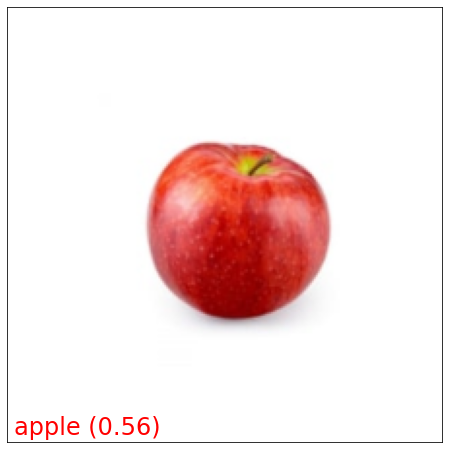

In [ ]:
import cv2
from matplotlib import pyplot as plt

# Predict the class of image
prediction = model.predict(img_tensor, verbose=0)

# Get the predicted class with the highest score
class_index = np.argmax(prediction[0])

# Get the predicted class name
class_name = list(class_names)[class_index]
text = class_name + " ({:.2f})".format(prediction[0][class_index])

# Show the output image
fig, ax = plt.subplots(figsize=(8, 8)) # define size of figure
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # display image in the figure
ax.tick_params(axis='both', which='both', length=0)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.annotate(text, (3, 220), fontsize=24, color="red")

# Print the prediction with its score
print("Predicted Class:", text)

**ขั้นตอนที่ 6** แสดงผลทำนายรูปทั้งหมดในโฟลเดอร์

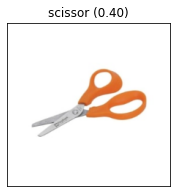

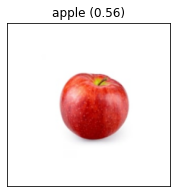

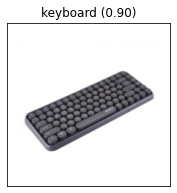

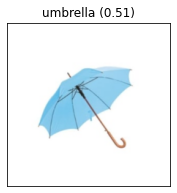

In [ ]:
import os
import matplotlib.pyplot as plt

# Loop through all images in the folder
folder_path = "/content/gdrive/MyDrive/Colab Notebooks/AIThaiGen/datasets/train images/"

# Because there are subfolders inside the directory,
# Loop to get first filename in each folder
filenames = []
for folder in os.listdir(folder_path):
  filenames.append(os.path.join(folder_path,
                                folder,
                                os.listdir(os.path.join(folder_path,folder))[0]
                                )
  )

# Loop through all images in the folder
for i, filename in enumerate(filenames): #os.listdir(folder_path)

    # Load the image
    img = cv2.imread(os.path.join(folder_path, filename))

    # Preprocess the image
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)) # resize to match inputs of model
    img_tensor = img / 255.0
    img_tensor = np.expand_dims(img, axis=0)

    # Make a prediction
    prediction = model.predict(img_tensor, verbose=0)

    # Get the class with the highest score
    class_index = np.argmax(prediction[0])
    class_score = prediction[0][class_index]

    # Plot the image and its prediction
    fig, ax = plt.subplots(figsize=(3, 3)) # define size of figure
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # display image in the figure
    ax.tick_params(axis='both', which='both', length=0)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    plt.title(f'{list(class_names)[class_index]} ({class_score:.2f})')

# Show all the subplots
plt.show()